Monday December 14 2015, QuantEcon Discrete Dynamic Programming

### Dynamic programming problem
Consider the following dynamic programming problem stated in recursive form with the following Functional Equation:
\begin{equation}
v(s) = \max_{a \in F(s)} u(s, a) + \beta \int v(s') Q(s'; s, a) \text{d}s'
\end{equation}
where $F(s)$ denotes the feasible choices of $a$ when the state is $s$. Note that the transition probabilities depend both on the current state and the action.

#### Notation and expectations
Denote by $\sigma$ a policy function. Denote the Markov Chain induced by policy $\sigma$ by $Q_{\sigma}(s',s) \equiv Q(s'; s, \sigma(s))$ and, analogously, $u_\sigma(s) \equiv u(s, \sigma(s))$.

The expected time $T$ payoff from a policy function $\sigma$ is starting from state $s_0$ is the $s_0$ entry of the vector obtained from applying the stochastic matrix (whose rows sum to $1$) to the vector $r$:
\begin{equation*}
E_0 \ \left[ \beta^T u(s, \sigma(s)) \lvert \ s_0 \right] = \beta^T Q^T_\sigma u_\sigma[s_0].
\end{equation*}

#### Principle of optimality
Denote by $v_\sigma$ the expected value from using policy function $\sigma$. The $s_0$ entry of the vector $v_\sigma$ reads:
\begin{equation*}
v_\sigma(s_0) = E_0 \ \left[ \sum_{t=0}^\infty \beta^t u(s_t, \sigma(s_t)) \ \bigg\lvert \ s_0 \right] = \sum_{t=0}^\infty \beta^t Q^t_\sigma u_\sigma[s_0].
\end{equation*}
Denote by $v^*$ the value function at the optimum and the optimal policy function $\sigma^*$:
\begin{align*}
v^*(s) \equiv & \max_{\sigma} \left\{v_\sigma(s)\ \lvert \ \sigma(\tilde{s}) \in F(\tilde{s}) \quad \forall \tilde{s} \right\} \\
\sigma^*(s) \equiv & \ \arg\max_{\sigma} \left\{v_\sigma(s)\ \lvert \ \sigma(\tilde{s}) \in F(\tilde{s}) \quad \forall \tilde{s} \right\}. 
\end{align*}

The principle of optimality states conditions such that $v^* = v$ where $v$ solves the functional equation and $\sigma^*(s)$ is $v-$greedy in the sense that $\sigma^*(s) = \ \arg\max_{a \in F(s)} u(s, a) + \beta \int v(s') Q(s'; s, a) \text{d}s'$.

### Computational algorithm
Parameters:
- $N_z, z_{min}, z_{max}$: number of shocks, minimum shock, maximum shock
- $N_s, s_{min}, s_{max}$: number of states, minimum state, maximum state
- $N_a, a_{min}, a_{max}$: number of actions, minimum action, maximum action
- $\beta$: discount factor
- $u$: an $N_z \times N_s \times N_a$ matrix of benefit for shock $z$, state $s$ and action $a$. (It can also be a function evaluated on the grid.)
- $Q(a)$: an $N_z \times N_z$ stochastic matrix whose rows sum to $1$; one for each $a$ if action affects the Markov Chain.

Note that $F(s)$ can be encoded in the definition of $u$ whereby $u(s,a) = -np.inf$ if $a \notin F(s)$.

#### Value function iteration
Compute $v_{t+1}$:
\begin{equation*}
v_{t+1}(z, s) = \max_{a \in F(z, s)} u(a, z, s) + \beta \sum_{z'} v_t(z', s'(a, z, s)) Q(z'; z).
\end{equation*}
where $z$ denote the shock and $s$ denote the state variable, either by interpolation or by comparison of evaluations on a grid until
\begin{equation*}
\lvert \lvert v_{t+1} - v_t \lvert \lvert \leq tol \frac{1-\beta}{2 \beta}
\end{equation*}.


### TO DO:
- write a discrete dynamic programming algorithm for:
Growth model with CRRA and uniformly distributed income shocks
    - compute the dynamic of the state $Q_{\sigma^*}$ when the agent follows the optimal policy $\sigma^*$

- write a discrete dynamic programming algorithm for:
with iid and with Markov shocks
 - value function iteration
 - policy function iteration
 - modified policy function iteration

- Check again the log Growth model without risk

- compare time of execution

- Solve REE
- Solve Huggett
- Solve Aiyagari
- Solve dynamics of Angeletos

In [50]:
from __future__ import division
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from numpy import log
from scipy.optimize import fminbound
from scipy import interpolate
from scipy import interp

def ValueFunctionIterator_income_risk(v, u, beta, f, delta, n, k):
    """
    Bellman_consumption_saving operator for a consumption-saving problem
    Note that this operator does not interpolate, it maximizes on a grid.
    v is the initial guess of value function
    u is the utility function of the consumer
    beta is the discount factor
    f is the production function
    delta is the depreciation rate
    n is the size of the grid
    k is the grid of possible levels of capital
    """
    C = np.tile(f(k), (1, n)) - np.tile(k.T, (n, 1)) + (1 - delta) * np.tile(k, (1, n)) # Possible consumption levels
    C[C< 1e-6] = 1e-6 # To satisfy the constraint that consumption has to be positive.
    U = u(C) # Utility levels
    U[C< 1e-9] = -np.infty #to address the fact that the utility is bounded below
    VP = U + beta * np.tile(v, (n, 1))
    vprime = np.nanmax(VP, axis = 1)
    return vprime

def value_function_iteration(max_iter, tol, v, u, beta, f, delta, n, k):
    dist = tol + 1
    for it in range(max_iter):
        vprime = ValueFunctionIterator_consumption_investment(v, u, beta, f, delta, n, k)
        dist = np.max(np.absolute(v - vprime)) #supremum norm of the difference between two subsequent value functions
        v = vprime #update the guess
        if dist < tol:
            print it, '= number of iterations'
            return vprime
            break
    else:
        print 'not converged'        
        return vprime

485 = number of iterations


(9.9999999999999995e-07, 3.0)

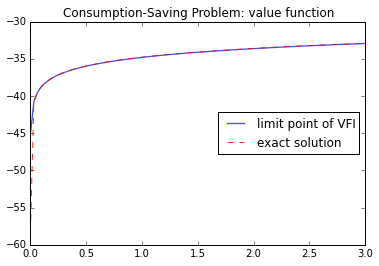

In [56]:
#Parameters
tol = 1e-10 #Tolerance level below which convergence is considered done
max_iter = 560 #Maximum number of iterations
n = 100 #number of grid points
grid_min = 1e-6 #grid_min, grid_max : minimum and maximum points of the grid
grid_max = 3
alpha = 0.65 #Coefficient of the Cobb-Douglas production technology
theta = 1 #Total Factor Productivity
beta = 0.95 #Patience parameter
delta = 1 #Depreciation rate
# Grid
k = np.linspace(grid_min, grid_max, n)
k.shape = (n, 1)


# Production technology
def f(x):
    return theta * x**(alpha)
# Utility function
def u(x):
    return log(x)

"""
Exact solution for the case with
    - full depreciation delta = 1,
    - log utility, 
    - Cobb-Douglas utility: theta = 1 and f(x)=theta*x**alpha
"""
c_1 = log(1 - alpha * beta)/(1 - beta) + log(alpha * beta) * alpha * beta / ((1 - alpha * beta) * (1 - beta))
c_2 = alpha / (1 - alpha * beta)
def v_star(k):
    return c_1 + c_2 * log(k)
vstar = np.array(v_star(k))
def policy_star(k):
    return (1- alpha * beta) * k**alpha
consumptionstar = np.array(policy_star(k))

""" 
Value Function Iteration
"""
init_v = np.linspace(0,100,n) # Initial guess of value function
init_v.shape = (1, n)
v = value_function_iteration(max_iter, tol, init_v, u, beta, f, delta, n, k)

fig, ax0 = plt.subplots()
ax0.plot(k, v, 'b-', linewidth=1.3, label='limit point of VFI', alpha=0.7)
ax0.plot(k, vstar, 'r--', linewidth=0.9, label='exact solution', alpha=0.9)
ax0.legend(loc='center right')
ax0.set_title('Consumption-Saving Problem: value function')
#ax0.set_ylim(-60, -30)
ax0.set_xlim(np.min(k), np.max(k))